In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
import numpy as np
from matplotlib.pyplot import *
import npp

In [3]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

## Create fake dataset with specific variance properties

In [1168]:
# partitions are always listed in the order (A, B, C, AB, AC, BC, ABC)
part_names = ('A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC')

# which partitions are combined to get each full feature space?
combs = [[0, 3, 4, 6],
         [1, 3, 5, 6],
         [2, 4, 5, 6]]

# total_variance is total fraction of non-noise variance in responses
total_variance = 0.05

# true_variances is proportion of variance assigned to each partition
#true_variances = np.ones(7) # each partition is equal
#true_variances = np.array([1088, 662, 9501, 251, 284, 1872, 555]).astype(float) # values from speech experiment
true_variances = np.array([0, 662, 9501, 251, 284, 1872, 555]).astype(float) # values from speech experiment
#true_variances = np.array([1, 1, 1, 1, 1, 10.0, 1])
true_variances = true_variances / true_variances.sum() * total_variance

noise_variance = 1.0 - true_variances.sum()

# P_parts is number of components that together describe the variance in each partition
#P_parts = [1] * 7 # 1 component in each partition
P_parts = [2] * 7 # 1 component in each partition
#P_parts = [10] * 7 # 10 component in each partition
#P_parts = [10, 10, 900, 10, 10, 10, 10]

# P_models contains size of each feature space (each must be bigger than sum of constituent parts)
#P_models = [300, 50, 1000] # approximately like speech experiment
#P_models = [50, 50, 50]
P_models = [50, 10, 300]
#P_models = [9, 5, 19] # like Mark's experiment

# Pnoise_models is number of noise features in each feature space
Pnoise_models = [P - np.array(P_parts)[c].sum() for P,c in zip(P_models, combs)]

# N_R is number of training (regression) timepoints, N_P is number of validation (prediction) timepoints
N_R, N_P = 3737, 300 # like speech experiment
#N_R, N_P = 1260, 126 # like Mark's experiment

# M is number of voxels to simulate
M = 500

In [1169]:
print "True variance in each partition:", true_variances

True variance in each partition: [ 0.     0.003  0.036  0.001  0.001  0.007  0.002]


In [1170]:
# Generate timecourses for each partition
X_parts = [np.random.randn(p, N_R + N_P) for p in P_parts]
print "X_parts[0].shape", X_parts[0].shape
XX = np.corrcoef(np.vstack(X_parts))

# Orthogonalize timecourses across and within partitions?
orthogonalize = True
if orthogonalize:
    cat_orthog_X_parts, _, _ = np.linalg.svd(np.vstack(X_parts).T, full_matrices=False)
    X_parts = np.vsplit(cat_orthog_X_parts.T, np.cumsum(P_parts)[:-1])
    XX_orthog = np.corrcoef(np.vstack(X_parts))

# Generate "true" weights used to construct Y
Btrue_parts = [np.random.randn(p, M) for p in P_parts]
print "Btrue_parts[0].shape", Btrue_parts[0].shape

# Generate output timecourses for each partition
Y_parts = [B.T.dot(X).T for X,B in zip(X_parts, Btrue_parts)]
print "Y_parts[0].shape", Y_parts[0].shape

# Rescale timecourses for each partition to have appropriate variance
scaled_Y_parts = [Y / Y.std(0) * np.sqrt(tv) for Y,tv in zip(Y_parts, true_variances)]
print "scaled_Y_parts[0].shape", scaled_Y_parts[0].shape

# Generate noise timecourses scaled to have appropriate variance
Y_noise = np.random.randn(N_R + N_P, M)
scaled_Y_noise = Y_noise / Y_noise.std(0) * np.sqrt(noise_variance)
print "scaled_Y_noise.shape", scaled_Y_noise.shape

# Construct Y from combination of partition timecourses
Y_total = np.array(scaled_Y_parts).sum(0) + scaled_Y_noise
zY_total = npp.zs(Y_total)
print "Y_total.shape", Y_total.shape

X_parts[0].shape (2, 4037)
Btrue_parts[0].shape (2, 500)
Y_parts[0].shape (4037, 500)
scaled_Y_parts[0].shape (4037, 500)
scaled_Y_noise.shape (4037, 500)
Y_total.shape (4037, 500)


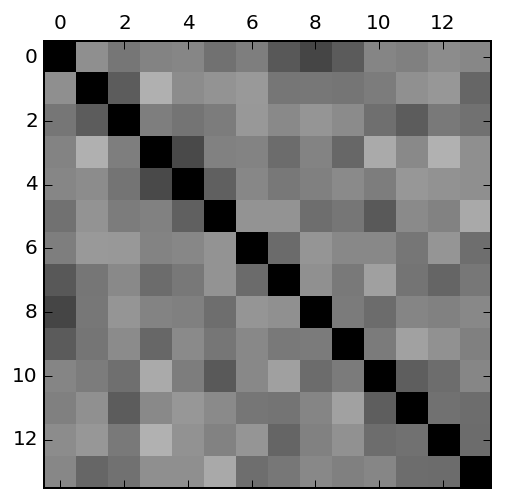

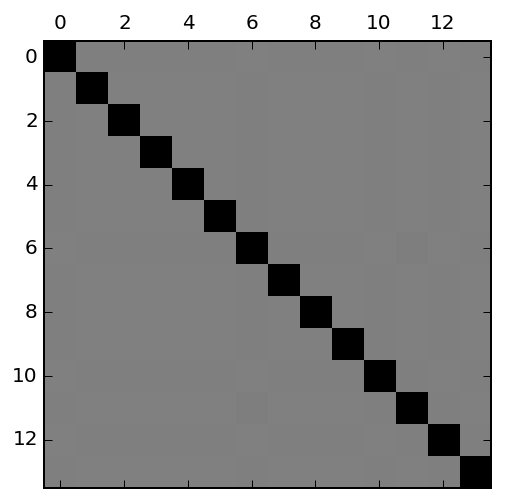

In [1171]:
# Visualize original and orthogonalized partition timecourse correlation matrices
# (to check orthogonalization)
matshow(XX, vmin=-0.1, vmax=0.1);
matshow(XX_orthog, vmin=-0.1, vmax=0.1);

In [1172]:
# Generate feature timecourses
# Stack together partition features to make "true" features for each feature space
Xtrue_feats = [np.vstack([X_parts[c] for c in comb]) for comb in combs]
print "Xtrue_feats[0].shape", Xtrue_feats[0].shape

# Generate noise features to round out each feature space
Xnoise_feats = [np.random.randn(Pnoise, N_R + N_P) for Pnoise in Pnoise_models]
#Xnoise_feats = [np.zeros((Pnoise, N_R + N_P)) for Pnoise in Pnoise_models]
#Xnoise_feats = [0.1 * np.random.randn(Pnoise, N_R + N_P) for Pnoise in Pnoise_models]
print "Xnoise_feats[0].shape", Xnoise_feats[0].shape

# Generate matrices to mix real and noise features in each space
mixing_mats = [np.random.randn(P, P) for P in P_models]
print "mixing_mats[0].shape", mixing_mats[0].shape

# Use mixing matrices to generate feature timecourses
use_mixing = True

if use_mixing:
    X_feats = [m.dot(np.vstack([Xt, Xn])) for m,Xt,Xn in zip(mixing_mats, Xtrue_feats, Xnoise_feats)]
else:
    X_feats = [np.vstack([Xt, Xn]) for m,Xt,Xn in zip(mixing_mats, Xtrue_feats, Xnoise_feats)]
print "X_feats[0].shape", X_feats[0].shape

# Bulk up skinny feats with extra shit to mash bias
Pmax = max(P_models)
bulked_X_feats = [np.vstack([X, np.random.randn(Pmax - P, N_R + N_P)]) for X,P in zip(X_feats, P_models)]
print "bulked_X_feats[0].shape", bulked_X_feats[0].shape

Xtrue_feats[0].shape (8, 4037)
Xnoise_feats[0].shape (42, 4037)
mixing_mats[0].shape (50, 50)
X_feats[0].shape (50, 4037)
bulked_X_feats[0].shape (300, 4037)


## Fit models and estimate variance partitions


Fitting model A
(50, 4037)
Theor. rsq: 0.004, corr-based: 0.002, rsq: -0.009

Fitting model B
(10, 4037)
Theor. rsq: 0.013, corr-based: 0.013, rsq: 0.010

Fitting model C
(300, 4037)
Theor. rsq: 0.047, corr-based: 0.018, rsq: -0.040

Fitting model A, B
(60, 4037)
Theor. rsq: 0.014, corr-based: 0.009, rsq: -0.002

Fitting model A, C
(350, 4037)
Theor. rsq: 0.047, corr-based: 0.017, rsq: -0.053

Fitting model B, C
(310, 4037)
Theor. rsq: 0.050, corr-based: 0.020, rsq: -0.038

Fitting model A, B, C
(360, 4037)
Theor. rsq: 0.050, corr-based: 0.018, rsq: -0.052


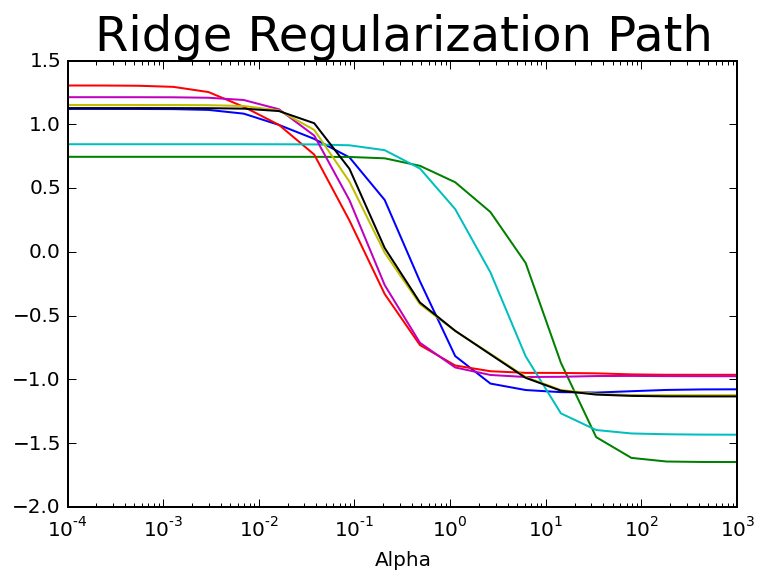

In [1179]:
# Fit some models
use_ols = False # True: models fit with OLS; False: models fit with ridge
use_features = "raw" # "raw": as-is; "bulked": expanded features; "same": add noise so each model is same
ridge_optimize_corr = True # (ridge only) True: optimize ridge alpha for correlation; False: optimize for R^2

from itertools import combinations, chain
feature_combs = list(chain(*[combinations(range(3), n) for n in [1, 2, 3]])) # feature spaces to use in each model

rsq_corr = lambda c: (c ** 2) * np.sign(c) # r -> r^2

import ridge
alphas = np.logspace(-4, 3, 20)

B_est = [] # estimated weights (not used for anything currently)
corr_est = [] # estimated r^2 from correlation
rsq_est = [] # estimated R^2 from sum of squared error

if not use_ols: figure()
Psum = sum(P_models)
for comb in feature_combs:
    print "\nFitting model %s" % ", ".join([['A','B','C'][c] for c in comb])
    thisP = np.array(P_models)[list(comb)].sum()
    
    if use_features == "raw":
        Xcomb = npp.zs(np.vstack([X_feats[c] for c in comb]).T).T
    elif use_features == "bulked":
        Xcomb = npp.zs(np.vstack([bulked_X_feats[c] for c in comb]).T).T # <- bulked gives best results!! ??!!?!
    elif use_features == "same":
        Xcomb = npp.zs(np.vstack([X_feats[c] for c in comb] + [np.random.randn(Psum - thisP, N_R + N_P)]).T).T
    else:
        raise ValueError(use_features)
    
    print Xcomb.shape
    
    if use_ols:
        wts, res, ranks, sings = np.linalg.lstsq(Xcomb.T[:N_R], zY_total[:N_R])
    else:
        wts, vcorrs, valphas, bscorrs, valinds = ridge.bootstrap_ridge(Xcomb.T[:N_R], zY_total[:N_R],
                                                                       Xcomb.T[N_R:], zY_total[N_R:],
                                                                       alphas=alphas,
                                                                       nboots=5,
                                                                       chunklen=40,
                                                                       nchunks=5,
                                                                       use_corr=ridge_optimize_corr)
    if not use_ols: semilogx(alphas, npp.zs(bscorrs.mean(2).mean(1)))
    
    B_est.append(np.vstack(wts).T)
    preds = np.dot(Xcomb.T[N_R:], wts)
    corrs = [np.corrcoef(pred, Y[N_R:])[0,1] for pred,Y in zip(preds.T, zY_total.T)]
    rsqs = [1 - (Y[N_R:] - pred).var() / Y[N_R:].var() for pred,Y in zip(preds.T, zY_total.T)]
    corr_est.append(corrs)
    rsq_est.append(rsqs)
    
    theoretical_rsq = true_variances[list(set.union(*[set(combs[c]) for c in comb]))].sum()
    avg_corr_rsq = rsq_corr(np.array(corrs)).mean()
    avg_rsq = np.array(rsqs).mean()
    print "Theor. rsq: %0.3f, corr-based: %0.3f, rsq: %0.3f" % (theoretical_rsq, avg_corr_rsq, avg_rsq)

if not use_ols: xlabel("Alpha"); title("Ridge Regularization Path");

In [1180]:
# Correct variance partitions to nearest legal value

import scipy.optimize

# A . x >= 0, where x is vector of model R^2 for models (A, B, C, AB, AC, BC, ABC)
# this is a set of constraints on the variances explained by different models
# and this is almost certainly an over-parameterization of the problem
A = np.array([[-1, 0, 0, 1, 0, 0, 0],
              [0, -1, 0, 1, 0, 0, 0],
              [1, 1, 0, -1, 0, 0, 0],
              [-1, 0, 0, 0, 1, 0, 0],
              [0, 0, -1, 0, 1, 0, 0],
              [1, 0, 1, 0, -1, 0, 0],
              [0, -1, 0, 0, 0, 1, 0],
              [0, 0, -1, 0, 0, 1, 0],
              [0, 1, 1, 0, 0, -1, 0],
              [-1, 0, 0, 0, 0, 0, 1],
              [0, -1, 0, 0, 0, 0, 1],
              [0, 0, -1, 0, 0, 0, 1],
              [0, 0, 0, -1, 0, 0, 1],
              [0, 0, 0, 0, -1, 0, 1],
              [0, 0, 0, 0, 0, -1, 1],
              [1, 1, 1, 0, 0, 0, -1],
              [0, 0, 0, 1, 1, 0, -1],
              [0, 0, 0, 1, 0, 1, -1],
              [0, 0, 0, 0, 1, 1, -1],
              [1, 0, 0, 0, 0, 1, -1],
              [0, 1, 0, 0, 1, 0, -1],
              [0, 0, 1, 1, 0, 0, -1],
              [0, 0, -1, 0, 1, 1, -1],
              [0, -1, 0, 1, 0, 1, -1],
              [-1, 0, 0, 1, 1, 0, -1]])

##  B . x = partition areas, where x is vector of model R^2 for models (A, B, C, AB, AC, BC, ABC)
B = np.array([[0, 0, 0, 0, 0, -1, 1], # Abc
              [0, 0, 0, 0, -1, 0, 1], # aBc
              [0, 0, 0, -1, 0, 0, 1], # abC
              [0, 0, -1, 0, 1, 1, -1], # ABc
              [0, -1, 0, 1, 0, 1, -1], # AbC
              [-1, 0, 0, 1, 1, 0, -1], # aBC
              [1, 1, 1, -1, -1, -1, 1], # ABC
             ])

def correct_rsqs(b, neg_only=True):
    maxs = A.dot(np.nan_to_num(b))
    #maxs = B.dot(np.nan_to_num(b))
    minfun = lambda x: (x ** 2).sum()
    #minfun = lambda x: np.abs(x).sum()

    biases = np.zeros((maxs.shape[1], 7)) + np.nan
    for vi in range(M):
        if not (vi % 1000):
            print "%d / %d" % (vi, M)
        
        if neg_only:
            bnds = [(None, 0)] * 7
        else:
            bnds = [(None, None)] * 7
        res = scipy.optimize.fmin_slsqp(minfun, np.zeros(7),
                                        f_ieqcons=lambda x: maxs[:,vi] - A.dot(x),
                                        #f_ieqcons=lambda x: maxs[:,vi] - B.dot(x),
                                        bounds=bnds, iprint=0)
        biases[vi] = res
    
    # compute fixed (legal) variance explained values for each model
    fixed_b = np.array(b) - np.array(biases).T

    orig_parts = B.dot(b)
    fixed_parts = B.dot(fixed_b)
    
    return biases, orig_parts, fixed_parts

# estimate biases, original partitions, and fixed partitions using r^2
corr_biases, corr_orig_parts, corr_fixed_parts = correct_rsqs(rsq_corr(np.array(corr_est)), neg_only=True)

# estimate biases, original partitions, and fixed partitions using R^2
rsq_biases, rsq_orig_parts, rsq_fixed_parts = correct_rsqs(np.array(rsq_est), neg_only=True)

0 / 500
0 / 500


In [1181]:
np.array(rsq_est).shape

(7, 500)

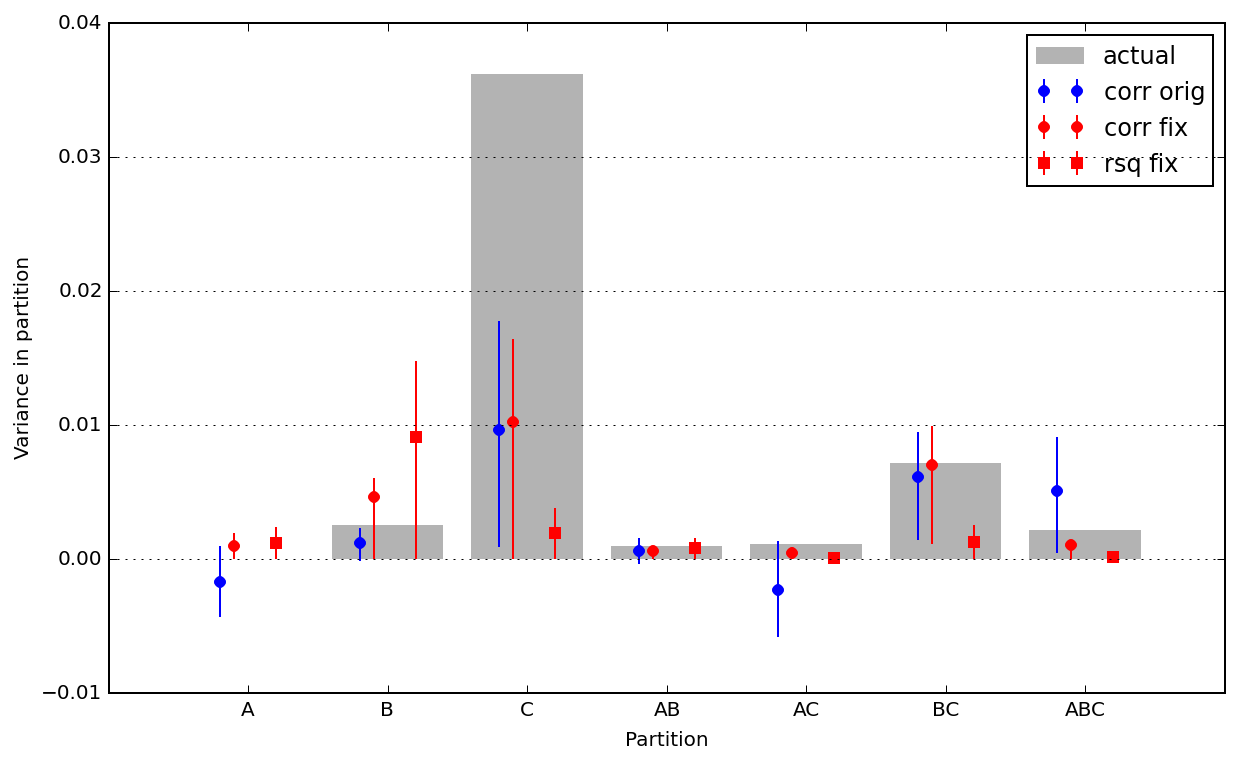

In [1182]:
# Plot actual vs. estimated variance in each partition
figure(figsize=(10,6))
bar(range(7), true_variances, align='center', edgecolor='none', facecolor="0.7", label="actual")

errtype = "perc" # "std": standard deviation, "perc": 10th-90th percentiles, "sem": standard error of the mean
if errtype == "std":
    errfun = lambda x: x.std(1)
elif errtype == "perc":
    errfun = lambda x: np.abs(np.percentile(x, [25, 75], axis=1) - x.mean(1))
elif errtype == "sem":
    errfun = lambda x: x.std(1) / np.sqrt(x.shape[1])

eargs = dict(capsize=0, mec='none')
x = np.arange(7)
errorbar(x - 0.2, corr_orig_parts.mean(1), yerr=errfun(corr_orig_parts), fmt='bo', label="corr orig", **eargs)
errorbar(x - 0.1, corr_fixed_parts.mean(1), yerr=errfun(corr_fixed_parts), fmt='ro', label="corr fix", **eargs)

#errorbar(x + 0.1, rsq_orig_parts.mean(1), yerr=errfun(rsq_orig_parts), fmt='bs', label="rsq orig", **eargs)
errorbar(x + 0.2, rsq_fixed_parts.mean(1), yerr=errfun(rsq_fixed_parts), fmt='rs', label="rsq fix", **eargs)

xticks(range(7), part_names);
grid(axis='y'); ylabel('Variance in partition'); legend(); xlabel("Partition");

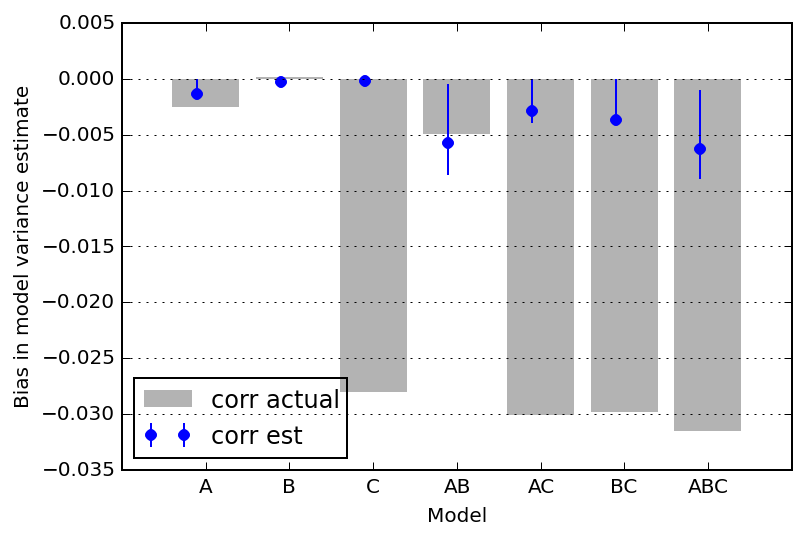

In [1183]:
# Plot actual vs. estimated biases for each partition

theoretical_rsqs = [true_variances[list(set.union(*[set(combs[c]) for c in comb]))].sum() for comb in feature_combs]
actual_corr_biases = rsq_corr(np.array(corr_est)).mean(1) - theoretical_rsqs
actual_rsq_biases = np.array(rsq_est).mean(1) - theoretical_rsqs

bar(x, actual_corr_biases, align='center', edgecolor='none', facecolor="0.7", label="corr actual")
#bar(x, actual_rsq_biases, align='center', edgecolor='none', facecolor="0.4", label="rsq actual", width=0.4)
errorbar(x - 0.1, corr_biases.mean(0), yerr=errfun(corr_biases.T), fmt='bo', label="corr est", **eargs)
#errorbar(x + 0.1, rsq_biases.mean(0), yerr=errfun(rsq_biases.T), fmt='ro', label="rsq est", **eargs)
xticks(range(7), part_names);
grid(axis='y');
xlim(-1, 7); legend(loc="lower left");
ylabel("Bias in model variance estimate");
xlabel("Model");

In [1184]:
# Compute and compare error, variance and bias of each estimate

# Mean squared error (MSE): how wrong, in total, is the estimate?
corr_orig_errs = ((corr_orig_parts.T - true_variances) ** 2).mean()
corr_fixed_errs = ((corr_fixed_parts.T - true_variances) ** 2).mean()

rsq_orig_errs = ((rsq_orig_parts.T - true_variances) ** 2).mean()
rsq_fixed_errs = ((rsq_fixed_parts.T - true_variances) ** 2).mean()

print "Corr MSE. Orig: %f, Fixed: %f, Ratio: fixed %0.3fx better" % (corr_orig_errs, corr_fixed_errs, corr_orig_errs / corr_fixed_errs)
print "Rsq MSE.  Orig: %f, Fixed: %f, Ratio: fixed %0.3fx better\n" % (rsq_orig_errs, rsq_fixed_errs, rsq_orig_errs / rsq_fixed_errs)
print "Corr vs. Rsq fixed MSE: corr %0.3fx better\n" % (rsq_fixed_errs / corr_fixed_errs)

# Variance: how variable is the estimate across voxels?
corr_orig_var = corr_orig_parts.var(1).mean()
corr_fixed_var = corr_fixed_parts.var(1).mean()

rsq_orig_var = rsq_orig_parts.var(1).mean()
rsq_fixed_var = rsq_fixed_parts.var(1).mean()

print "Corr Variance. Orig: %f, Fixed: %f, Ratio: fixed %0.3fx better" % (corr_orig_var, corr_fixed_var, corr_orig_var / corr_fixed_var)
print "Rsq  Variance. Orig: %f, Fixed: %f, Ratio: fixed %0.3fx better\n" % (rsq_orig_var, rsq_fixed_var, rsq_orig_var / rsq_fixed_var)
print "Corr vs. Rsq fixed variance: corr %0.3fx better\n" % (rsq_fixed_var / corr_fixed_var)

# Bias: how biased is the estimate? (i.e. how far is mean estimate from true value)
corr_orig_bias = corr_orig_parts.mean(1) - true_variances
corr_fixed_bias = corr_fixed_parts.mean(1) - true_variances
corr_bias_ratio = np.abs(corr_orig_bias).sum() / np.abs(corr_fixed_bias).sum()

rsq_orig_bias = rsq_orig_parts.mean(1) - true_variances
rsq_fixed_bias = rsq_fixed_parts.mean(1) - true_variances
rsq_bias_ratio = np.abs(rsq_orig_bias).sum() / np.abs(rsq_fixed_bias).sum()

print "Corr Bias. \nOrig: %s, \nFixed: %s, \nRatio: fixed %0.3fx better\n" % (corr_orig_bias, corr_fixed_bias, corr_bias_ratio)
print "Rsq  Bias. \nOrig: %s, \nFixed: %s, \nRatio: fixed %0.3fx better\n" % (rsq_orig_bias, rsq_fixed_bias, rsq_bias_ratio)
print "Corr vs. Rsq fixed bias: corr %0.3fx better" % (np.abs(rsq_fixed_bias).sum() / np.abs(corr_fixed_bias).sum())

Corr MSE. Orig: 0.000160, Fixed: 0.000136, Ratio: fixed 1.178x better
Rsq MSE.  Orig: 0.001397, Fixed: 0.000204, Ratio: fixed 6.862x better

Corr vs. Rsq fixed MSE: corr 1.498x better

Corr Variance. Orig: 0.000055, Fixed: 0.000038, Ratio: fixed 1.443x better
Rsq  Variance. Orig: 0.000298, Fixed: 0.000024, Ratio: fixed 12.646x better

Corr vs. Rsq fixed variance: corr 0.616x better

Corr Bias. 
Orig: [-0.002 -0.001 -0.027 -0.    -0.003 -0.001  0.003], 
Fixed: [ 0.001  0.002 -0.026 -0.    -0.001 -0.    -0.001], 
Ratio: fixed 1.194x better

Rsq  Bias. 
Orig: [-0.014 -0.001 -0.087 -0.001  0.002 -0.001 -0.   ], 
Fixed: [ 0.001  0.007 -0.034 -0.    -0.001 -0.006 -0.002], 
Ratio: fixed 2.058x better

Corr vs. Rsq fixed bias: corr 1.631x better
